# ECE4782 Deep Learning Labs
## 3. Recurrent Neural Networks

In this chapter, we will learn how to implement a recurrent neural network by using PyTorch.

#### 0. Prepare Data

The same dateset we used in the previous chapter of CNN will be used.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('seizure.csv')
labels = df['y'].values
labels = labels - 1
data = df.loc[:, 'X1':'X178'].values

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=4782)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=4782)

print(X_train)
print(X_train.shape)

[[ -75  -77  -88 ...  -66  -69  -80]
 [ -49  -48  -44 ...  -46  -46  -43]
 [ -33  -42  -50 ... -139 -144 -142]
 ...
 [  66   10  -22 ...  -44  -41  -41]
 [ -48  -56  -72 ... -173 -159 -147]
 [ -69  -23   32 ...   64  120  142]]
(7360, 178)


#### 1. Loading Datasets
Shape of input tensor is (batch, seq_len, input_size), different from the one used for CNN in the previous chapter. In fact, the default shape of input for recurrent layer modules in PyTorch such as RNN, GRU, and LSTM is (seq_len, batch, input_size). You can choose your preferred shape, but **do not forget to set proper boolean value for `batch_first` argument for recurrent layer modules**.

As our current dataset has a shape of (num_subject, seq_len) and each time step has 1D signal, we need to add a dummy axis to make it as a 3D tensor. In the following codes, you can see `unsqueeze(dim)` function on Tensor which adds a new axis (dimension).

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# lets fix the random seeds for reproducibility.
torch.manual_seed(4782)
if torch.cuda.is_available():
    torch.cuda.manual_seed(4782)

trainset = TensorDataset(torch.from_numpy(X_train.astype('float32')).unsqueeze(2), torch.from_numpy(y_train.astype('long')))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True, num_workers=2)

validset = TensorDataset(torch.from_numpy(X_valid.astype('float32')).unsqueeze(2), torch.from_numpy(y_valid.astype('long')))
validloader = torch.utils.data.DataLoader(validset, batch_size=10, shuffle=False, num_workers=2)

testset = TensorDataset(torch.from_numpy(X_test.astype('float32')).unsqueeze(2), torch.from_numpy(y_test.astype('long')))
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False, num_workers=2)

classes = ('Seizure', 'TumorArea', 'HealthyArea', 'EyesClosed', 'EyesOpen')

#### 2. Define RNN class

In [3]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class RecurNet(nn.Module):
    def __init__(self):
        super(RecurNet, self).__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=32, num_layers=2, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(in_features=32, out_features=5)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x


model = RecurNet()

Again, let's define a class for our model. In this tutorial we use one of gated units, Gated Recurrent Unit (GRU), as our recurrent layer. `nn.GRU` is a implementatoin of (multi-layered) GRU. 'multi-layered' means you can easily define several layers of GRU by putting the number of layers as input argument for `num_layers`. On the other hand, `nn.GRUCell` can be used when you want to construct more complex architecture between each recurrent layer. We use 2-layers of GRU for this tutorial.

**Note again that, we need to carefully set the value for `batch_first` for all types of RNN module.**

At line 9, we retrieve the hidden unit outputs from the last recurrent layer for the last time step. To be specific, `nn.GRU` returns an tuple of `output, h_n` where `output` is the output value of hidden units from the last layer for **ALL** time steps and `h_n` is the same value for the last time step only. Therefore, `x, _ = self.rnn(x)` at line 8, we get a Tensor `x` in a shape of (batch, seq_len, hidden_size) since we set `batch_first=True`. We then extract the values for the last time step by `x[:, -1, :]`. If we set `batch_first=False`, indexing should be modified also.

We add a fully-connected layer on the top of the recurrent layers. 

#### 3. Define a Loss function and optimizer

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

We use the same loss function and the same optimizer from the previous chapter.

#### 4. Train the network
Also, we can use the same procedure for training the network.

In [5]:
cuda = torch.cuda.is_available()
if cuda:
    model = model.cuda()

train_losses = []
valid_losses = []

for epoch in range(15):  # loop over the dataset multiple times

    # set the model as train mode
    model.train()
    train_loss = 0.0
    train_counter = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, targets = data

        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += (loss.item() * inputs.size(0))
        train_counter += inputs.size(0)

    train_losses.append(train_loss/train_counter)
    
    # switch to evaluation mode
    model.eval()
    valid_loss = 0.0
    valid_counter = 0
    with torch.no_grad():
        for i, data in enumerate(validloader, 0):
            # get the inputs
            inputs, targets = data

            if cuda:
                inputs, targets = inputs.cuda(), targets.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            valid_loss += (loss.item() * inputs.size(0))
            valid_counter += inputs.size(0)
    valid_losses.append(valid_loss/valid_counter)
    
    print("epoch {}: train loss {}, validation loss {}".format(epoch, train_losses[-1], valid_losses[-1]))
    
print('Finished Training')

epoch 0: train loss 1.1584133819231521, validation loss 0.942846356526665
epoch 1: train loss 0.9103764427987777, validation loss 0.7842161371980024
epoch 2: train loss 0.7801736981769942, validation loss 0.7254805933360172
epoch 3: train loss 0.7450974498591993, validation loss 0.7716598787709422
epoch 4: train loss 0.7197924660842704, validation loss 0.727915875694674
epoch 5: train loss 0.6968295705383238, validation loss 0.6473826323028492
epoch 6: train loss 0.6818224801580705, validation loss 0.7010008606087902
epoch 7: train loss 0.6690982481586221, validation loss 0.6727589880642684
epoch 8: train loss 0.6604949179226938, validation loss 0.6632766154311274
epoch 9: train loss 0.6506587659899631, validation loss 0.6295573437667411
epoch 10: train loss 0.6463007195650236, validation loss 0.6494203240651152
epoch 11: train loss 0.6381759897238858, validation loss 0.6430701472513054
epoch 12: train loss 0.6279869884576487, validation loss 0.6308755788790144
epoch 13: train loss 0.6

We should check the learning curve always!

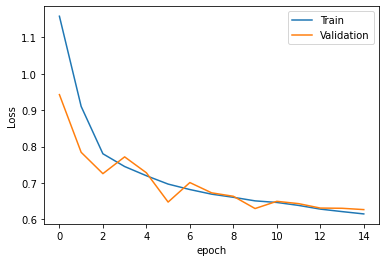

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(valid_losses)), valid_losses, label='Validation')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(loc="best")

#### 5. Test the network on the test data

In [7]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        # get the inputs
        inputs, targets = data

        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)        
        c = (predicted == targets).squeeze()
        for i, label in enumerate(targets):
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %s : %2d%% out of %d cases' % (classes[i], 100 * class_correct[i] / class_total[i], class_total[i]))

Accuracy of Seizure : 93% out of 497 cases
Accuracy of TumorArea : 56% out of 448 cases
Accuracy of HealthyArea : 52% out of 431 cases
Accuracy of EyesClosed : 62% out of 464 cases
Accuracy of EyesOpen : 83% out of 460 cases


Congratulations! We have completed the example of recurrent neural network!

We will try another way of using RNN in the next chapter with a slightly more complicated example.

### Exercise 1. Try to use different type of RNN cell (e.g. LSTM)

### Exercise 2. How do you compare the result with the one by CNN in the previous chapter? What about computation time?